# Time-series prediction with Keras `SimpleRNN` class
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536 ([LinkedIn](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), [Github](https://tirthajyoti.github.io))

For more tutorial-style notebooks on deep learning, **[here is my Github repo](https://github.com/tirthajyoti/Deep-learning-with-Python)**.

For more tutorial-style notebooks on general machine learning, **[here is my Github repo](https://github.com/tirthajyoti/Machine-Learning-with-Python)**.

---
### What is this Notebook about?
In this notebook, we show a building simple recurrent neural network (RNN) using Keras.

We will generate some synthetic time-series data by multiplying two periodic/ sinusoidal signals and adding some stochasticity (Gaussian noise). Then, we will take a small fraction of the data and train a simple RNN model with it and try to predict the rest of the data and see how the predictions match up with the ground truth.

-------------------------------------------------------------------------

### Qué veremos en este notebook?

En este notebook, veremos con construir una red neuronal recurrente simple (RNN) usando keras.

Vamos a generar un conjunto de datos sintéticos multiplicando dos señales una periodica y una sinusoidal, y además le añadiremos un poco de ruido a estas señales. Después tomaremos una muestra de estos datos para entrenar el modelo RNN con el que trataremos de predecir el resto de la serie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Total time points
N = 3004

Tp = 754 # Partition for train

np.random.seed(0)
t = np.arange(0,N)
x = (2*np.sin(0.02*t) * np.sin(0.03*t)) + 0.5*np.random.normal(size=N)

df = pd.DataFrame(x, columns=['Data'])
df.head()

,Data
0,0.882026
1,0.201278
2,0.494165
3,1.131226
4,0.952913


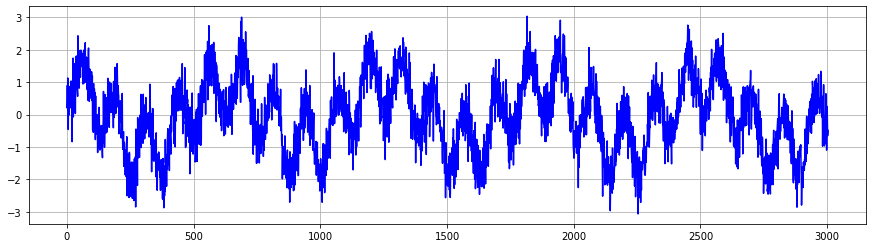

In [3]:
plt.figure(figsize=(15,4))
plt.plot(df,c='blue')
plt.grid(True);

### Split the values in train and test

So, we took only 25% of the data as training samples and set aside the rest of the data for testing. 

Looking at the time-series plot, we think **it is not easy for a standard model to come up with correct trend predictions.**

-------------------------------------------------------------------------

### Dividimos los valores en train y test

Vamos a coger únicamente el 25% de los datos para entrenar el modelo y el resto lo dejaremos para el conjunto de test.

Viendo el gráfico de la serie temporal, podemos pensar **que no será fácil realizar una predicción correcta si usamos modelos estandar**

In [4]:
values = df.values
train, test = values[0:Tp, :], values[Tp:N,:]

In [5]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (754, 1)
Test data length: (2250, 1)


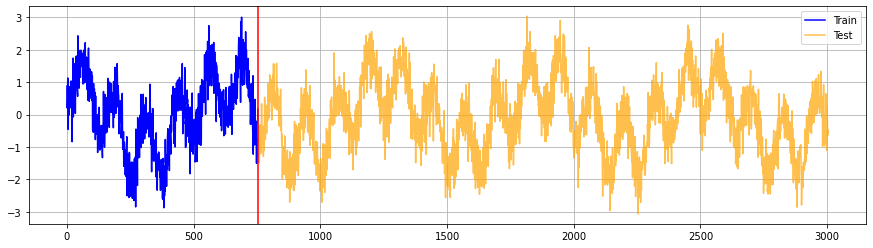

In [6]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.plot(index[0:Tp],train,c='blue')
plt.plot(index[Tp:N],test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.axvline(Tp, c="r")
plt.grid()

### Step (or _embedding_)
RNN model requires a step value that contains n number of elements as an input sequence.

Suppose x = {1,2,3,4,5,6,7,8,9,10}

for step=1, x input  and its y prediction become:

| x  | y  |
|---|---|
| 1  | 2  |
| 2  | 3  |
| 3  | 4  |
| ...  | ...  |
| 9  | 10  |

for step=3, x and y contain:

| x  | y  |
|---|---|
| 1,2,3  | 4  |
| 2,3,4  | 5  |
| 3,4,5  | 6  |
| ...  | ...  |
| 7,8,9  | 10  |

Here, we choose `step=4`. In more complex RNN and in particular for text processing, this is also called _embedding size_.

-------------------------------------------------------------------------

### Paso (o embedings)

Nuestra RNN requiere una serie de n valores que recibirá como imput para poder realizar una predicción. Para construir un dataset con secuencia de pasos o lags supondremos que en base a n (número de pasos) calcularemos el valor de y.

Supongamos que x = {1,2,3,4,5,6,7,8,9,10}

para step=1, el primer valor será nuestra *x* y el siguiente será *y*:

| x  | y  |
|---|---|
| 1  | 2  |
| 2  | 3  |
| 3  | 4  |
| ...  | ...  |
| 9  | 10  |

para step=3, *x* e *y* se construiran de la siguiente manera:

| x  | y  |
|---|---|
| 1,2,3  | 4  |
| 2,3,4  | 5  |
| 3,4,5  | 6  |
| ...  | ...  |
| 7,8,9  | 10  |

En nuestro caso usaremos un `step=4`

In [8]:
df2 = df.copy()
emb_size = 4
for i in range(1, emb_size+1):
    df2['lag' + str(i)] = df2['Data'].shift(i)

df2.dropna(inplace=True)
df2.reset_index(drop=True, inplace=True)

values = df2.values
trainX, trainY = values[0:Tp-emb_size,1:], values[0:Tp-emb_size,0]
testX, testY = values[Tp-emb_size:N-emb_size,1:], values[Tp-emb_size:N-emb_size,0]

print("Train data length:", trainX.shape)
print("Train target length:", trainY.shape)
print("Test data length:", testX.shape)
print("Test target length:", testY.shape)

Train data length: (750, 4)
Train target length: (750,)
Test data length: (2250, 4)
Test target length: (2250,)


In [9]:
df2

,Data,lag1,lag2,lag3,lag4
0,0.952913,1.131226,0.494165,0.201278,0.882026
1,-0.458801,0.952913,1.131226,0.494165,0.201278
2,0.517908,-0.458801,0.952913,1.131226,0.494165
3,-0.017500,0.517908,-0.458801,0.952913,1.131226
4,0.024131,-0.017500,0.517908,-0.458801,0.952913
...,...,...,...,...,...
2995,-0.558584,-1.096185,-0.556226,-0.882404,0.643616
2996,0.251637,-0.558584,-1.096185,-0.556226,-0.882404
2997,-0.285621,0.251637,-0.558584,-1.096185,-0.556226
2998,-0.650390,-0.285621,0.251637,-0.558584,-1.096185


In [10]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [11]:
trainX[:3]

array([[[ 1.13122556,  0.49416483,  0.20127834,  0.88202617]],

       [[ 0.95291252,  1.13122556,  0.49416483,  0.20127834]],

       [[-0.4588011 ,  0.95291252,  1.13122556,  0.49416483]]])

Para entrenar el modelo, necesito que los datos tengan la siguiente dimensión:

(750, 1, 4)

- 750: el número total de trozos 
- 1: una fila de datos
- 4: cada trozo tiene cuatro valores

En el caso de una imagen, recordemos con un ejemplo: 

(750, 28, 28)

750 imágenes de resolución 28x28

In [12]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (750, 1, 4) ,  (750,)
Test data shape: (2250, 1, 4) ,  (2250,)


### Keras model

- 128 neurons in the RNN layer
- 32 neurons in the densely connected layer
- A single neuron for the output layer. Predict a single number
- ReLu activation
- learning rate: 0.001

-------------------------------------------------------------------------

### Modelo de Keras

- 128 neuronas en la capa de RNN
- 32 neuronas en la segunda capa densa
- 1 única neurona en la capa de salida, para realizar una regresión.
- Usaremos ReLu como función de activación
- learning rate : 0.001

In [13]:
from tensorflow.keras.layers import Dense, LSTM

def build_simple_rnn(num_units=128, embedding=4, num_dense=32, lr=0.001):
    """
    Builds and compiles a RNN model
    Arguments:
             num_units: Number of units of a RNN layer
             embedding: Embedding length
             num_dense: Number de neuronas in the dense layer
             lr: Learning rate
     Returns:
             A compiled Keras model
    """
    model = Sequential()
    model.add(LSTM(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=lr),
                 metrics=['mse'])
    
    return model

In [14]:
model = build_simple_rnn()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 72,257
Trainable params: 72,257
Non-trainable params: 0
_________________________________________________________________


### A simple callback class to show a message every 50 epochs

In [16]:
'''
Enseña mensaje si la epoch es multiplo de 50 y no ha acabado de entrenar.
Cada vez que termina una epoch, keras llama a on_epoch_end()
'''
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

### Fit the model

Con batch_size = 16 lo que haríamos es que cogemos los datos de esta forma:

- (16, 1, 4)

Cogemos 16 trozos de 1 fila con 4 datos

In [17]:
batch_size = 16
num_epochs = 1000

In [18]:
model.fit(trainX,trainY,
         epochs=num_epochs,
         batch_size=batch_size,
         callbacks=[MyCallback()],verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


### Plot loss

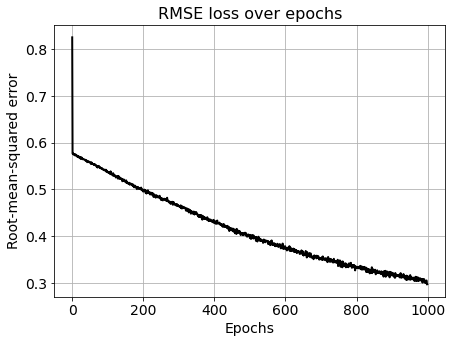

In [19]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

### Predictions
Note that the model was fitted only with the `trainX` and `trainY` data.

-------------------------------------------------------------------------

### Predicciones
El modelo ha sido entrenado únicamente con 'trainX' y 'trainY'.

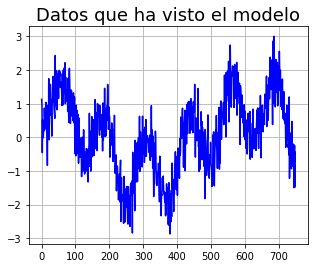

In [20]:
plt.figure(figsize=(5,4))
plt.title("Datos que ha visto el modelo",fontsize=18)
plt.plot(trainX[:,0][:,0],c='blue')
plt.grid(True)
plt.show()

In [21]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
predicted = np.concatenate((trainPredict,testPredict),axis=0)

71/71 [==============================] - 0s 886us/step


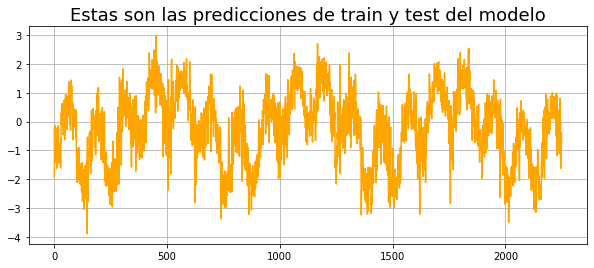

In [22]:
plt.figure(figsize=(10,4))
plt.title("Estas son las predicciones de train y test del modelo",fontsize=18)
plt.plot(testPredict,c='orange')
plt.grid(True);

### Comparing it with the ground truth (test set)

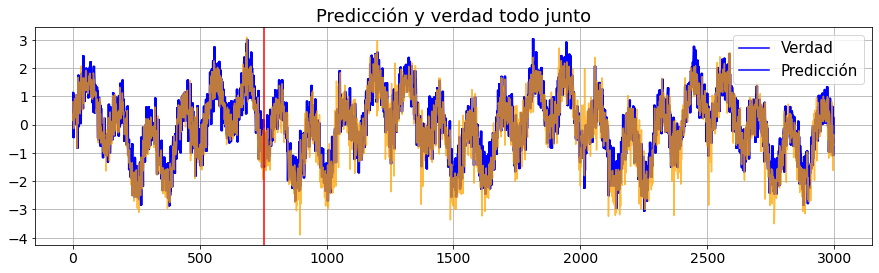

In [24]:
index = df2.index.values
plt.figure(figsize=(15,4))
plt.title("Predicción y verdad todo junto",fontsize=18)
plt.plot(index,df2,c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['Verdad','Predicción'], fontsize=15)
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

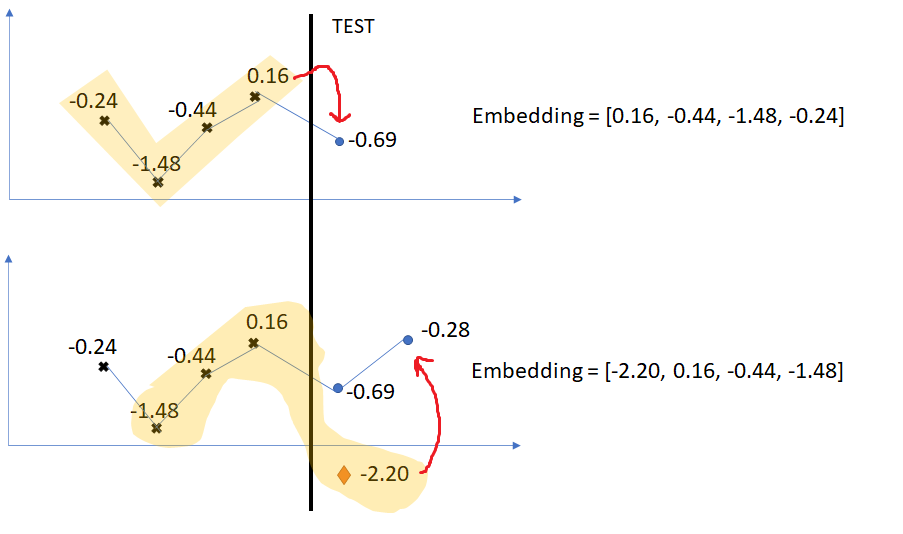

In [25]:
def prediction(model, x_test):
    preds = x_test[0]
    preds_out = []
    
    for i in range(len(x_test)):
        if i ==0:
            pred = model.predict(np.expand_dims(preds, axis=0)).reshape(-1)
        else: 
            pred = model.predict(np.expand_dims([preds], axis=0)).reshape(-1)
        preds_out.append(pred)

        preds2 = np.array([preds.reshape(-1)[0:-1]])
        
        '''
        Concatenamos la nueva, es decir, el nuevo t-1
        '''
        preds = np.c_[preds2, np.array([pred])][0]
    return preds_out


In [26]:
df2.iloc[749:752,]

,Data,lag1,lag2,lag3,lag4
749,0.167640,-0.443188,-1.482464,-0.247260,-0.461332
750,-0.698580,0.167640,-0.443188,-1.482464,-0.247260
751,-0.288681,-0.698580,0.167640,-0.443188,-1.482464


In [27]:
testX[0]

array([[ 0.1676401 , -0.44318755, -1.48246442, -0.2472599 ]])

In [28]:
testY[0]

-0.6985804052510958

In [29]:
preds = testX[0]
preds_out=[]
i=0
pred = model.predict(np.expand_dims(preds, axis=0)).reshape(-1)
print(pred)
preds_out.append(pred)
preds2 = np.array([preds.reshape(-1)[0:-1]])
print(preds2)
preds = np.c_[np.array([pred]), preds2][0]
print(preds)

1/1 [==============================] - 0s 17ms/step
[-1.9403033]
[[ 0.1676401  -0.44318755 -1.48246442]]
[-1.94030333  0.1676401  -0.44318755 -1.48246442]


In [30]:
i=1
pred = model.predict(np.expand_dims([preds], axis=0)).reshape(-1)
print(pred)
preds_out.append(pred)
preds2 = np.array([preds.reshape(-1)[0:-1]])
print(preds2)
preds = np.c_[np.array([pred]), preds2][0]
print(preds)

1/1 [==============================] - 0s 27ms/step
[-0.16804847]
[[-1.94030333  0.1676401  -0.44318755]]
[-0.16804847 -1.94030333  0.1676401  -0.44318755]


In [31]:
preds_out

[array([-1.9403033], dtype=float32), array([-0.16804847], dtype=float32)]

In [32]:
trainPredict2 = prediction(model,trainX)
testPredict2 = prediction(model,testX)
predicted2 = np.concatenate((trainPredict2,testPredict2),axis=0)

1/1 [==============================] - 0s 19ms/step


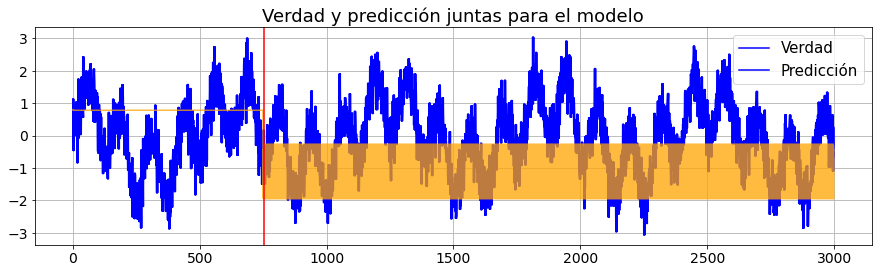

In [34]:
index = df2.index.values
plt.figure(figsize=(15,4))
plt.title("Verdad y predicción juntas para el modelo",fontsize=18)
plt.plot(index,df2, c='blue')
plt.plot(index,predicted2,c='orange',alpha=0.75)
plt.legend(['Verdad','Predicción'],fontsize=15)
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

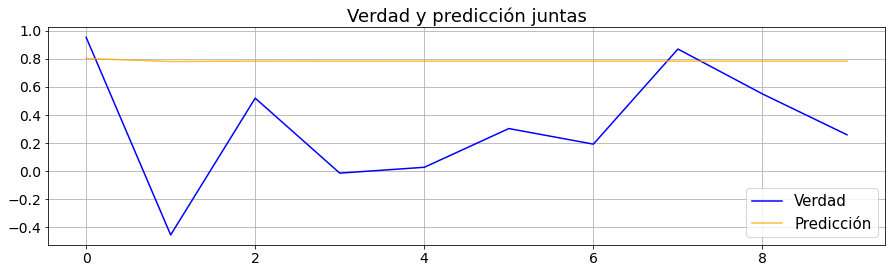

In [35]:
index = df2.index.values
plt.figure(figsize=(15,4))
plt.title("Verdad y predicción juntas",fontsize=18)
plt.plot(index[0:10],df2['Data'][0:10],c='blue')
plt.plot(index[0:10],predicted2[0:10],c='orange',alpha=0.75)
plt.legend(['Verdad','Predicción'],fontsize=15)

plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### How are the errors distributed?
The errors, or residuals, as they are called in a regression problem, can be plotted to see if they follow any specific distribution. In the generation process, we injected Gaussian noise, so we expect the error to follow the same pattern, _if the model has been able to fit to the real data correctly_.

In [36]:
error = predicted[Tp:N] - df2[Tp:N]
error = np.array(error).ravel()

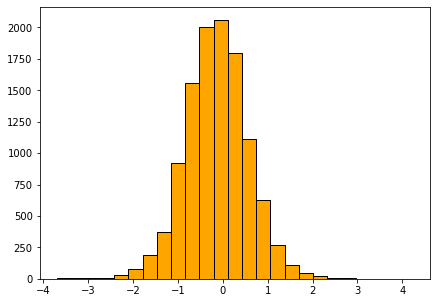

In [37]:
plt.figure(figsize=(7,5))
plt.hist(error,bins=25,edgecolor='k',color='orange');

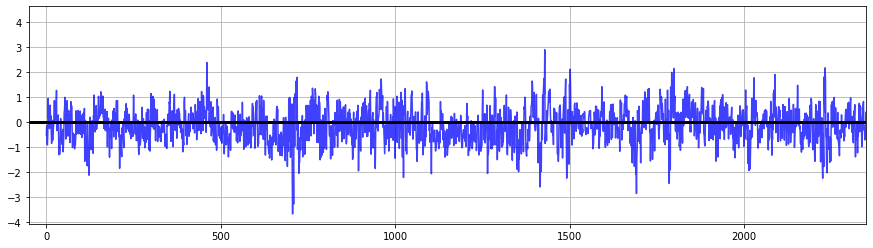

In [38]:
plt.figure(figsize=(15,4))
plt.plot(error,c='blue',alpha=0.75)
plt.hlines(y=0,xmin=-50,xmax=2400,color='k',lw=3)
plt.xlim(-50,2350)
plt.grid(True);

## Make the model better

Note, for running these experiments reasonably fast, we will fix the model size to be smaller than the model above. We will use a RNN layer with 32 neurons followed by a densely connected layer of 8 neurons.

### Varying the embedding/step size

In [39]:
def predictions(model,trainX,testX):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    predicted = np.concatenate((trainPredict,testPredict),axis=0)
    
    return predicted

In [40]:
def plot_compare(predicted, df2):
    index = df2.index.values
    plt.figure(figsize=(15,4))
    plt.title("Verdad frente a Predicción",fontsize=18)
    plt.plot(index,df2, color= 'g')
    plt.plot(index,predicted, color='orange',alpha=0.75)
    plt.legend(['Verdad','Predicción'],fontsize=15)
    plt.axvline(df2.index[Tp], c="r")
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [41]:
def prepare_data(step=4):
    df2 = df.copy()
    emb_size = step
    for i in range(1, emb_size+1):
        df2['lag' + str(i)] = df2['Data'].shift(i)

    df2.dropna(inplace=True)
    df2.reset_index(drop=True, inplace=True)

    values = df2.values

    trainX,trainY = values[0:Tp-emb_size ,1:],values[0:Tp-emb_size ,0],
    testX,testY = values[Tp-emb_size:N-emb_size,1:], values[Tp-emb_size:N-emb_size,0]
    
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    return trainX,testX,trainY,testY,df2

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def errors(testX, testY):
    y_true = testY
    y_pred = model.predict(testX)
    return mean_absolute_error(y_true,y_pred)

71/71 [==============================] - 0s 673us/step
Embedding size: 2
71/71 [==============================] - 0s 662us/step
MAE: 0.4681901713948163
----------------------------------------------------------------------------------------------------


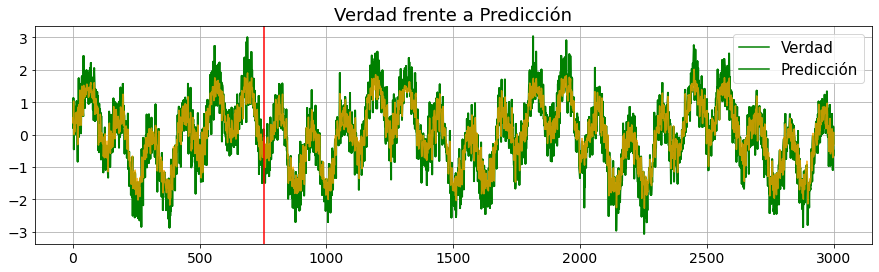


71/71 [==============================] - 0s 702us/step
Embedding size: 4
71/71 [==============================] - 0s 737us/step
MAE: 0.4404707442136911
----------------------------------------------------------------------------------------------------


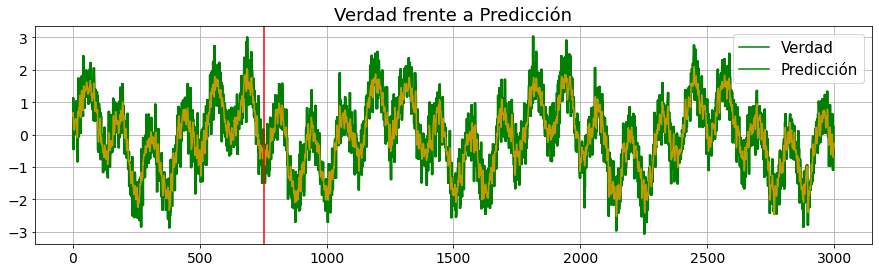


71/71 [==============================] - 0s 797us/step
Embedding size: 6
71/71 [==============================] - 0s 1ms/step
MAE: 0.4389905476039293
----------------------------------------------------------------------------------------------------


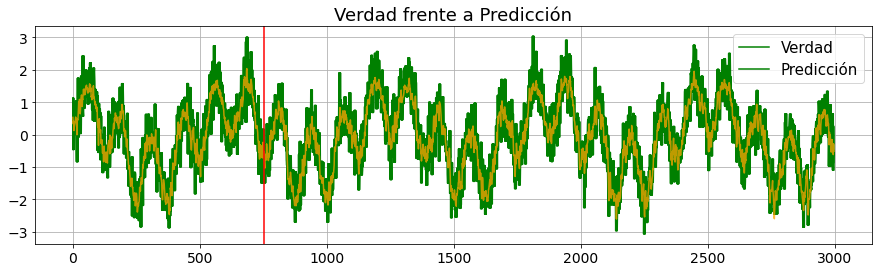


71/71 [==============================] - 0s 762us/step
Embedding size: 8
71/71 [==============================] - 0s 666us/step
MAE: 0.4389110266575331
----------------------------------------------------------------------------------------------------


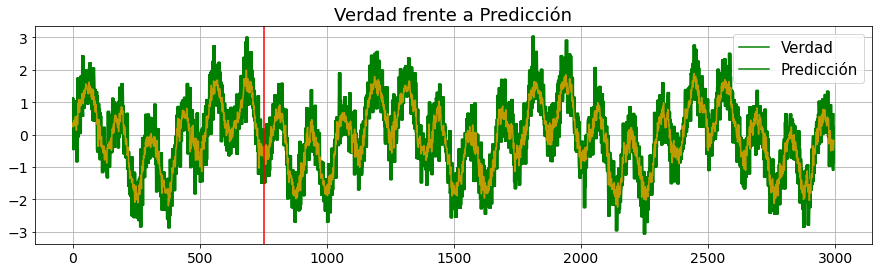


71/71 [==============================] - 0s 690us/step
Embedding size: 10
71/71 [==============================] - 0s 906us/step
MAE: 0.4724291745774289
----------------------------------------------------------------------------------------------------


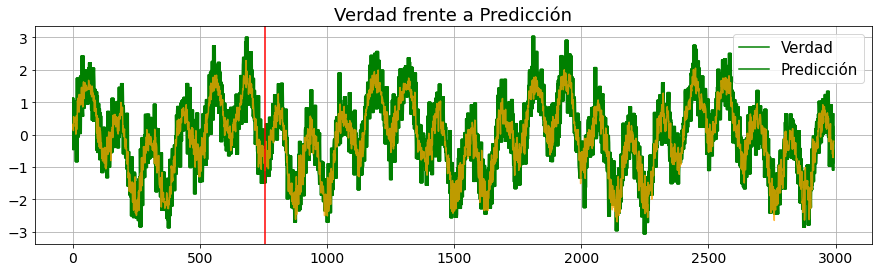


71/71 [==============================] - 0s 645us/step
Embedding size: 12
71/71 [==============================] - 0s 649us/step
MAE: 0.45648253835588065
----------------------------------------------------------------------------------------------------


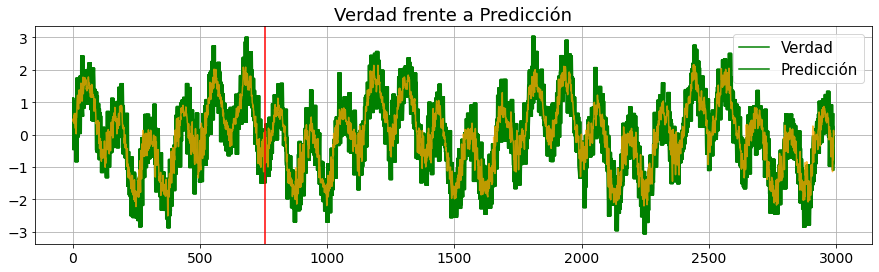

In [43]:
for s in [2,4,6,8,10,12]:
    trainX,testX,trainY,testY,df2 = prepare_data(s)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=s)
    batch_size=16
    num_epochs = 100
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Embedding size: {}".format(s))
    print("MAE:", errors(testX, testY))
    print("-"*100)
    plot_compare(preds, df2)
    print()

### Number of epochs

71/71 [==============================] - 0s 700us/step
Ran for 100 epochs
71/71 [==============================] - 0s 707us/step
MAE: 0.43116248364696436
----------------------------------------------------------------------------------------------------


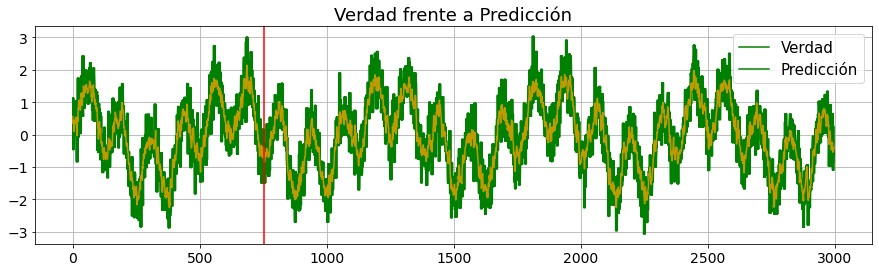


71/71 [==============================] - 0s 959us/step
Ran for 200 epochs
71/71 [==============================] - 0s 676us/step
MAE: 0.45443625733083726
----------------------------------------------------------------------------------------------------


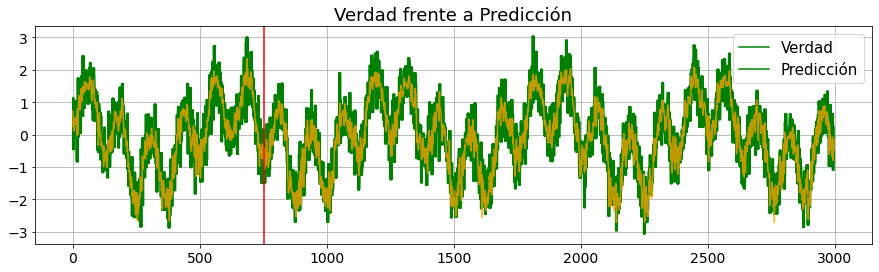


71/71 [==============================] - 0s 820us/step
Ran for 300 epochs
71/71 [==============================] - 0s 672us/step
MAE: 0.4594314372078543
----------------------------------------------------------------------------------------------------


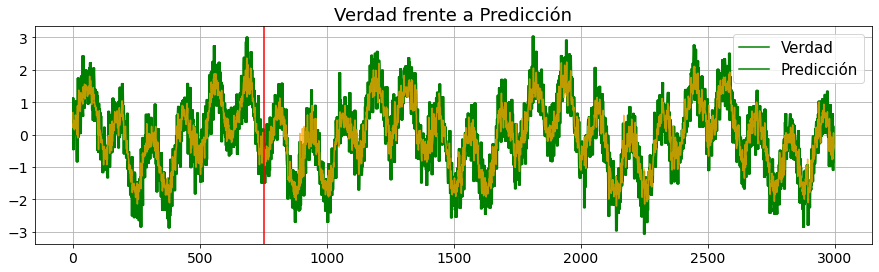


71/71 [==============================] - 0s 655us/step
Ran for 400 epochs
71/71 [==============================] - 0s 757us/step
MAE: 0.47055700843057297
----------------------------------------------------------------------------------------------------


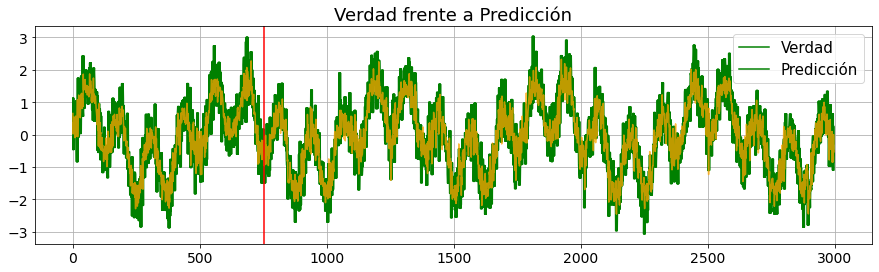


71/71 [==============================] - 0s 747us/step
Ran for 500 epochs
71/71 [==============================] - 0s 1ms/step
MAE: 0.4874721922852069
----------------------------------------------------------------------------------------------------


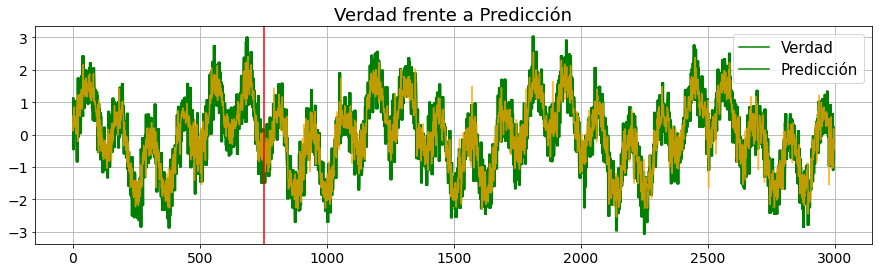

In [44]:
'''
Probemos ahora con una ventana grande (8), y unas cuantas epochs mas
'''
for e in [100,200,300,400,500]:
    trainX, testX, trainY, testY, df2 = prepare_data(6)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=6)
    batch_size=16
    num_epochs = e
    model.fit(trainX,trainY, 
          epochs=e, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Ran for {} epochs".format(e))
    print("MAE:", errors(testX, testY))
    print("-"*100)
    plot_compare(preds, df2)
    print()

### Batch size

71/71 [==============================] - 0s 780us/step
Ran with batch size: 4
71/71 [==============================] - 0s 739us/step
MAE: 0.47979090992003975
----------------------------------------------------------------------------------------------------


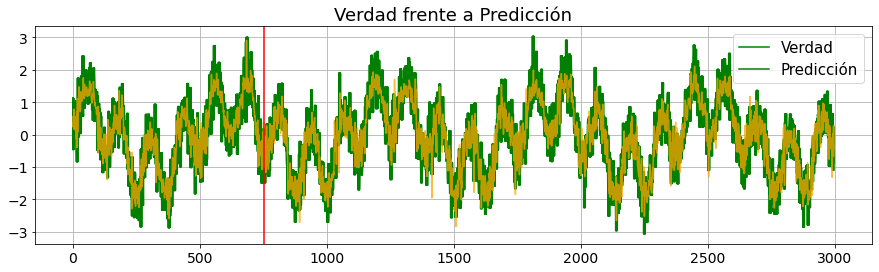


71/71 [==============================] - 0s 938us/step
Ran with batch size: 8
71/71 [==============================] - 0s 760us/step
MAE: 0.46456456654702377
----------------------------------------------------------------------------------------------------


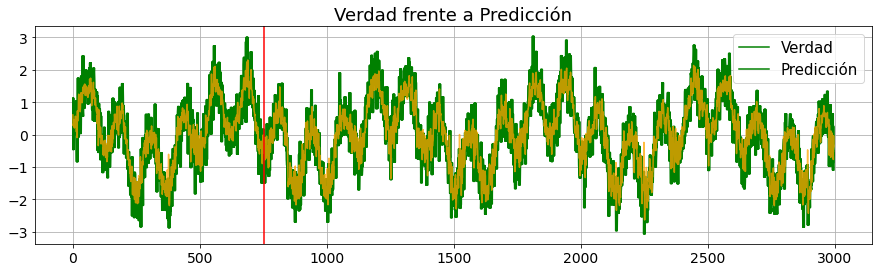


71/71 [==============================] - 0s 681us/step
Ran with batch size: 16
71/71 [==============================] - 0s 746us/step
MAE: 0.4498088961140122
----------------------------------------------------------------------------------------------------


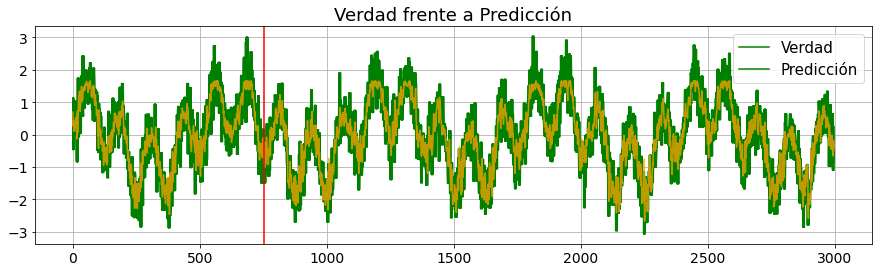


71/71 [==============================] - 0s 686us/step
Ran with batch size: 32
71/71 [==============================] - 0s 717us/step
MAE: 0.4493146821396567
----------------------------------------------------------------------------------------------------


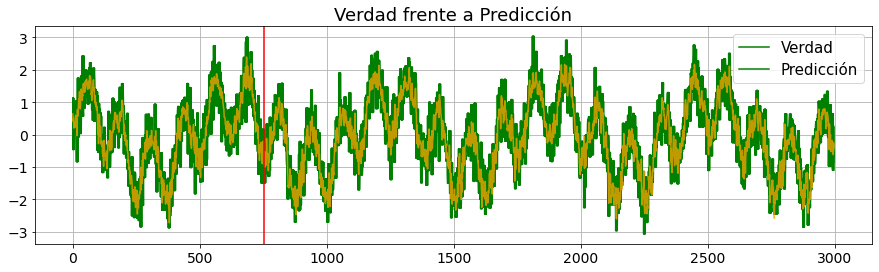


71/71 [==============================] - 0s 711us/step
Ran with batch size: 64
71/71 [==============================] - 0s 679us/step
MAE: 0.4401393408305044
----------------------------------------------------------------------------------------------------


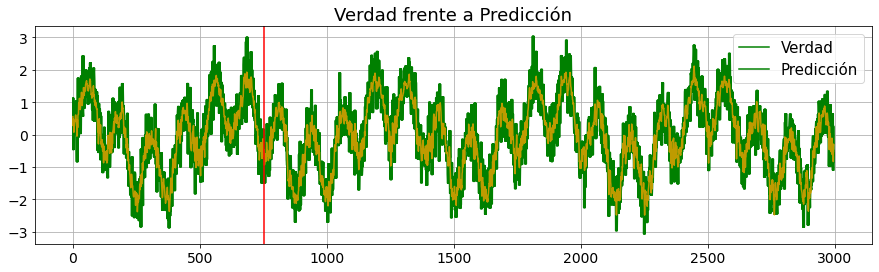

In [45]:
for b in [4,8,16,32,64]:
    trainX,testX,trainY,testY, df2 = prepare_data(6)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=6)
    batch_size=b
    num_epochs = 250
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=b,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Ran with batch size: {}".format(b))
    print("MAE:", errors(testX, testY))
    print("-"*100)
    plot_compare(preds, df2)
    print()

### Summary

Clearly, following trends were observed,

- Too small embedding size is not useful but a very long embedding is also not effective. An embedding of 8 looks good for this data.
- More epochs are not always better. Probably we are suffering overfitting
- A batch size of 32 or 64 looks optimal.

Ultimately, an exhaustive hyperparameter tuning is needed for the best overall performance.

-------------------------------------------------------------------------

### Resumiendo

Hemos podido observar los siguientes tips.

- Un tamaño de embbeding no es muy útil, pero un tamaño muy grande tampoco es muy efectiva, según lo que hemos podido observar un tamaño de 8 es un valor optimo para nuestros datos.
- Más épocas no siempre es mejor, lo más probable es que estemos sobreentrenando el modelo
- Un tamaño de salto optimo puede ser 32 o 64.

Para finalizar, un proceso exhaustivo a la hora de buscar los hiperparámetros es necesario para conseguir el mejor rendimiendo en el modelo.

### Vamos a tratar de predecir la misma serie con modelos de TS, SARIMA

In [48]:
# librerias
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

#from pmdarima.arima import auto_arima
#from pmdarima.arima import ARIMA
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [49]:
import itertools

In [50]:
p = range(0,3)
d = range(0,3)
q = range(0,3)
s = range(11,13)

pdqs = list(itertools.product(p, d, q, s))
pdqs

results = []
for param in pdqs:
    model_arima = ARIMA(train,seasonal_order=param)
    model_arima_fit = model_arima.fit()
    results.append((param,model_arima_fit.aic))
    
resultados_df = pd.DataFrame(results, columns=['ARIMA params', 'AIC']).sort_values('AIC')
resultados_df.head()

,ARIMA params,AIC
40,"(2, 0, 2, 11)",1633.904895
41,"(2, 0, 2, 12)",1653.593626
22,"(1, 0, 2, 11)",1697.541658
23,"(1, 0, 2, 12)",1717.558819
38,"(2, 0, 1, 11)",1729.187803


In [55]:
test

array([[-0.69858041],
       [-0.28868085],
       [-0.36986456],
       ...,
       [-0.28562077],
       [-0.65038963],
       [-0.4885951 ]])

MSE: 1.3720470212666922


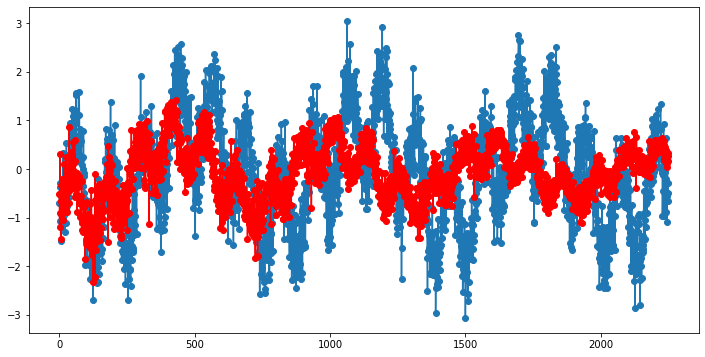

In [58]:
model = ARIMA(train, seasonal_order=(2,0,2,200))
predictions = model.fit().predict(754,754+2249)
print("MSE:", mean_squared_error(test,predictions))
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(test).values,'o-')
plt.plot(pd.DataFrame(predictions).values,'o-',color='red');